In [1]:
from graph_stuff import generate_all_clusters, score_cluster, create_groupings, evaluate_clusters

def find_best_clustering(adj_matrix, conductance_weight=0.5, density_weight=0.5):
    """Find the best clustering using greedy approach."""
    n_nodes = adj_matrix.shape[0]
    available_nodes = list(range(n_nodes))
    clusters = []
    
    while len(available_nodes) > 1:
        import math
        max_cluster_size = min(math.floor(math.sqrt(len(n_nodes))), 8)
        if max_cluster_size < 2:
            break
        
        # Generate all possible clusters
        possible_clusters = generate_all_clusters(available_nodes, max_cluster_size)
        
        best_cluster = None
        best_score = -1
        
        # Find best cluster
        from tqdm.notebook import tqdm
        for cluster in tqdm(possible_clusters, desc="Possible clusters", leave=False):
            score = score_cluster(cluster, adj_matrix, conductance_weight, density_weight)
            if score > best_score:
                best_score = score
                best_cluster = cluster
        
        if best_cluster is None or best_score <= 0:
            break
        
        # Add best cluster and remove its nodes from available
        clusters.append(best_cluster)
        available_nodes = [node for node in available_nodes if node not in best_cluster]
    
    # Add remaining nodes as singleton clusters
    for node in available_nodes:
        clusters.append([node])
    
    return clusters

def cluster_grouping(word_array, model, device='cpu'):
    """
    Cluster a group of words using the model to create adjacency matrix.
    
    Args:
        word_array: List of tensors representing IPA words
        model: Trained transformer model
        device: Device to run model on
    
    Returns:
        List of clusters, where each cluster is a list of indices
    """
    n_words = len(word_array)
    
    # Create adjacency matrix
    adj_matrix = torch.zeros((n_words, n_words))
    
    model.eval()
    with torch.no_grad():
        for i in range(n_words):
            for j in range(i+1, n_words):
                # Create word pair tensor
                word_pair = torch.stack([word_array[i], word_array[j]], dim=0).unsqueeze(0).to(device)
                
                # Create masks (True for padding tokens)
                mask1 = (word_array[i] == 0).unsqueeze(0).to(device)
                mask2 = (word_array[j] == 0).unsqueeze(0).to(device)
                word_pair_masks = torch.stack([mask1, mask2], dim=1).to(device)
                
                # Get similarity score
                similarity = model(word_pair, word_pair_masks).item()
                
                # Fill both triangles of the matrix
                adj_matrix[i, j] = similarity
                adj_matrix[j, i] = similarity

    # Find best clustering
    predicted_clusters = find_best_clustering(adj_matrix)
    
    return predicted_clusters

def cluster_and_evaluate_all_meanings(df, model, ipa_to_ids, device='cpu'):
    """Process all word meanings and evaluate clustering using the modular approach."""
    # Step 1: Preprocessing
    groupings = create_groupings(df, ipa_to_ids)
    
    results = {}
    
    # Step 2 & 3: Clustering and Evaluation
    from tqdm.notebook import tqdm
    for meaning, (word_array, cognate_class_label_array) in tqdm(groupings.items(), total=len(groupings), desc="Groupings"):
        #print(f"\nProcessing meaning: {meaning}")
        #print(f"Number of words: {len(word_array)}")
        
        # Step 2: Clustering
        predicted_clusters = cluster_grouping(word_array, model, device)
        
        # Step 3: Evaluation
        evaluation_results = evaluate_clusters(predicted_clusters, cognate_class_label_array, meaning)
        
        results[meaning] = evaluation_results
        
        #print(f"Predicted clusters: {predicted_clusters}")
        #print(f"True classes: {cognate_class_label_array}")
        #print(f"Accuracy: {evaluation_results['accuracy']:.3f}")
    
    return results

In [2]:
import pandas as pd
import torch
import numpy as np

# Load data
df = pd.read_csv('data/ielexData.csv')

# Create IPA to ID mapping
import joblib
ipa_embedder = joblib.load("data/embeddings/34.joblib")
ipa_to_ids = ipa_embedder.char_to_idx

# Example of using the modular approach:
from transformer_stuff import TransformerCognateModel
model = torch.load('TransformerCognateModel_34.pt', weights_only=False)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model.to(device)

TransformerCognateModel(
  (embedder): Embedding(129, 34, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=34, out_features=34, bias=True)
        )
        (linear1): Linear(in_features=34, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=34, bias=True)
        (norm1): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, ou

In [3]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

ielexPairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ielexPairs.append((word1, word2, label))

def preprocess(all_pairs, ipa_embedder, device):
    from itertools import chain

    max_length = 0
    for pair in all_pairs:
        for word in pair:
            length = len(word)
            if length > max_length:
                max_length = length
    
    batches = torch.empty((len(all_pairs), 2, max_length), dtype=torch.int, device=device)
    batches_masks = torch.zeros((len(all_pairs), 2, max_length), dtype=torch.bool, device=device)

    from tqdm.notebook import tqdm
    for pair_index, pair in tqdm(enumerate(all_pairs), total=len(all_pairs), desc="Creating batches"):
        for word_index, word in enumerate(pair):
            for letter_index, letter in enumerate(word):
                batches[pair_index, word_index, letter_index] = ipa_embedder.char_to_idx[letter]
            
            batches_masks[pair_index, word_index, len(word):] = True

    return (batches, batches_masks, max_length)

all_pairs = [row[:2] for row in ielexPairs]
all_labels = [row[2] for row in ielexPairs]

ldistance_operations, ldistance_masks, max_length = preprocess(all_pairs, ipa_embedder, device=device)
test_data = list(zip(ldistance_operations, ldistance_masks))

from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=1600, generator=torch.Generator(device=torch.get_default_device().type))

predicted_labels = []

from tqdm.notebook import tqdm
for batch in tqdm(test_loader, desc="Testing IELEX against GLED"):
    batch_predicted_labels = model(*batch).squeeze()
    batch_predicted_labels = (batch_predicted_labels > 0.5).int()
    predicted_labels.extend(batch_predicted_labels.tolist())

from sklearn.metrics import classification_report
print(classification_report(all_labels, predicted_labels))

Creating batches:   0%|          | 0/47274 [00:00<?, ?it/s]

torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([1600, 2, 39]) torch.Size([1600, 2, 39])
torch.Size([

In [ ]:
# Process a single meaning group
# meaning = 'few'
# if meaning in groupings:
#     word_array, cognate_labels = groupings[meaning]
#     clusters = cluster_grouping(word_array, model, device)
#     results = evaluate_clusters(clusters, cognate_labels, meaning)
#     print(f"Results for '{meaning}': {results}")

# Or process all meanings
all_results = cluster_and_evaluate_all_meanings(df, model, ipa_to_ids, device)

In [5]:
accuracies = [r['accuracy'] for r in all_results.values()]
print(f"\nOverall average accuracy: {np.mean(accuracies):.3f}")

f1s = [r['f1'] for r in all_results.values()]
print(f"\nOverall f1 score: {np.mean(f1s):.3f}")

nmis = [r['nmi'] for r in all_results.values()]
print(f"\nOverall nmi score: {np.mean(nmis):.3f}")


Overall average accuracy: 0.677

Overall f1 score: 0.309

Overall nmi score: 0.496


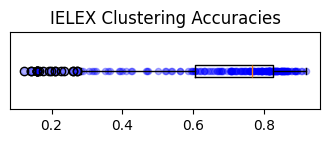

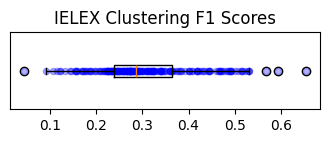

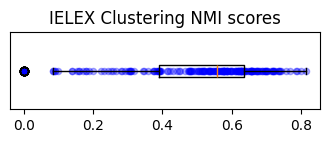

In [4]:
import matplotlib.pyplot as plt
from visualization_stuff import show_box_plot

show_box_plot(accuracies, title="IELEX Clustering Accuracies")
show_box_plot(f1s, title="IELEX Clustering F1 Scores")
show_box_plot(nmis, title="IELEX Clustering NMI scores")